# **ACML Assigment: Convolutional Autoencoders**

should we put smth about data and reconstruction??

In [1]:
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from torch.utils.data import random_split
from torchvision.datasets import CIFAR10

import os
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
def get_best_device():
    if torch.backends.mps.is_built():
        device = torch.device("mps")
        print("Using MPS (Apple Silicon GPU)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using CUDA (GPU)")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

In [3]:
EPOCHS = 2

## **Exercise 1**

1. Divide your dataset into training (80%), validation (10%) and test (10%). Normalize the data.

In [4]:
BATCH_SIZE = 512

transform_cifar = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
)


dataset = CIFAR10(root="data", download=True, train=True, transform=transform_cifar)
dataset_train, dataset_test, dataset_validation = random_split(
    dataset, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(42)
)


train_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4
)
test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)

Files already downloaded and verified


In [5]:
def grayscale_processing(img):
    if len(img.shape) == 3:
        img = img.mean(dim=0, keepdim=True)
        img = img.repeat(3, 1, 1)
    else:
        img = img.mean(dim=1, keepdim=True)
        img = img.repeat(1, 3, 1, 1)
    return img

In [6]:
def plot_examples(model, num_examples=5, grayscale=False):
    i = list(range(0, num_examples*5, 5))

    for j in i:
      img = dataset_test[j][0]
      img_processed = img
      n = 2

      if grayscale:
        img_processed = grayscale_processing(img)
        n = 3

      out = model(img_processed.unsqueeze(0))[0].detach().cpu().permute(1, 2, 0).numpy()
      img = img.permute(1, 2, 0).numpy()

      fig, ax = plt.subplots(1, n, figsize=(5*n, 5))
      ax[0].imshow(img)
      ax[0].set_title('Original Image')

      if grayscale:
        img_processed = img_processed.permute(1, 2, 0).numpy()
        ax[1].imshow(img_processed)
        ax[1].set_title('Input to NN')

      ax[n-1].imshow(out)
      ax[n-1].set_title('Reconstructed Image')
      plt.show()

2. Implement the autoencoder network specified above. Run the training for at least 10 epochs, and plot the
evolution of the error with epochs. Report also the test error.

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, encoder=None, decoder=None):
        super().__init__()

        self.device = get_best_device()
        self.loss_history = []
        self.test_loss_history = []
        self.criterion = nn.MSELoss().to(self.device)
        # self.criterion = nn.BCELoss().to(self.device)

        if encoder is None:
            self.encoder = nn.Sequential(
                nn.Conv2d(
                    in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1
                ),
                nn.ReLU(True),
                nn.MaxPool2d(2, 2),
                nn.Conv2d(
                    in_channels=8, out_channels=12, kernel_size=3, stride=1, padding=1
                ),
                nn.ReLU(True),
                nn.MaxPool2d(2, 2),
                nn.Conv2d(
                    in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1
                ),
                nn.ReLU(True),
            )
        else:
            self.encoder = encoder

        if decoder is None:
            self.decoder = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(
                    in_channels=16, out_channels=12, kernel_size=3, stride=1, padding=1
                ),
                nn.ReLU(True),
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(
                    in_channels=12, out_channels=3, kernel_size=3, stride=1, padding=1
                ),
                nn.Sigmoid(),
            )
        else:
            self.decoder = decoder

        self.to(self.device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def train(
        self, train_loader, test_loader, epochs=10, lr=0.1, grayscale_input=False
    ):
        optimizer = optim.Adam(self.parameters(), lr=lr)

        for epoch in range(epochs):
            epoch_loss = []
            for data in train_loader:
                x, _ = data
                x = x.to(self.device).float()
                optimizer.zero_grad()

                input = x
                if grayscale_input:
                    input = grayscale_processing(input)

                output = self(input)
                loss = self.criterion(output, x)
                epoch_loss.append(loss.item())
                loss.backward()
                optimizer.step()

            train_loss = np.mean(epoch_loss)
            test_loss = self.test_loss(test_loader)
            self.loss_history.append(train_loss)
            self.test_loss_history.append(test_loss)

            # if self.test_loss == min(self.test_loss_history):
            #     self.best_model = self.state_dict()

            print(
                f"Epoch {epoch+1}/{epochs} Train Loss: {train_loss}, Test Loss: {test_loss}"
            )

    def test_loss(self, test_loader):
        test_loss = []
        with torch.no_grad():
            for data in test_loader:
                x, _ = data
                x = x.to(self.device).float()
                output = self(x)
                loss = self.criterion(output, x)
                test_loss.append(loss.item())

        return np.mean(test_loss)

    def plot_loss(self):
        plt.plot(self.loss_history)
        plt.plot(self.test_loss_history)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Autoencoder Loss History")
        plt.show()

    def __call__(self, x):
        x = x.to(self.device).float()
        return self.forward(x)

In [8]:
autoencoder = Autoencoder()
autoencoder.train(train_loader, test_loader, epochs=EPOCHS, lr=0.001)
autoencoder.plot_loss()

Using MPS (Apple Silicon GPU)
Epoch 1/2 Train Loss: 0.036071871513430075, Test Loss: 0.019822662509977818


KeyboardInterrupt: 

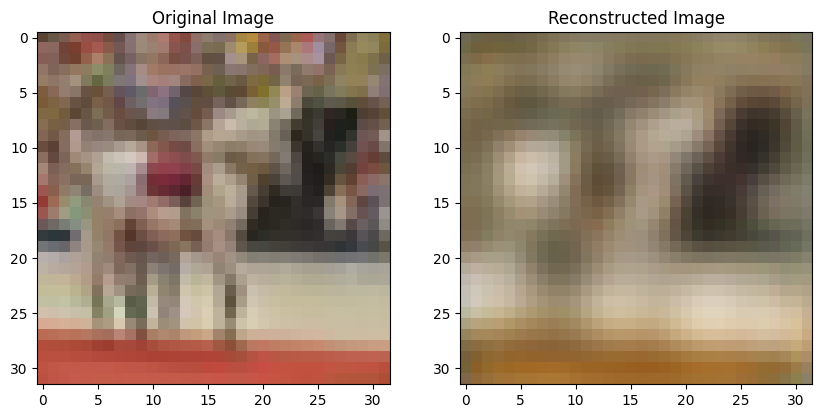

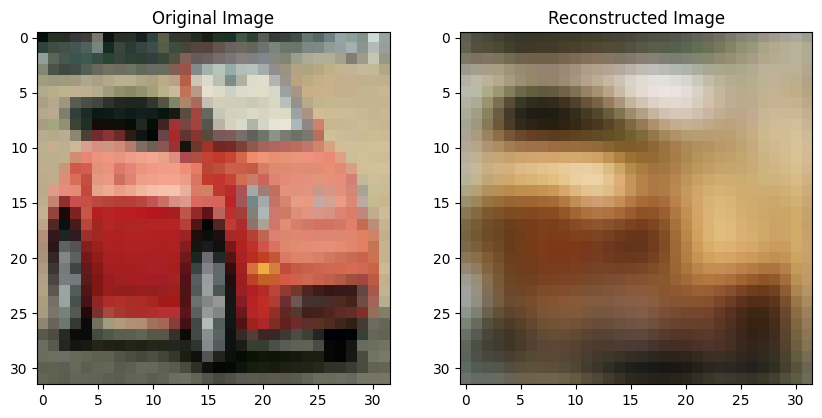

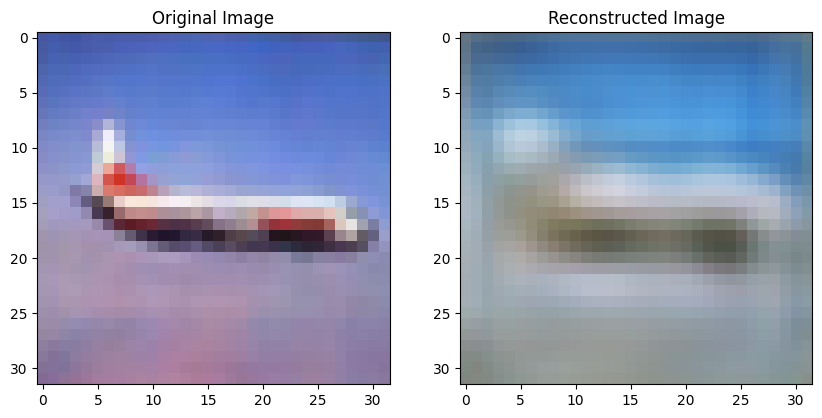

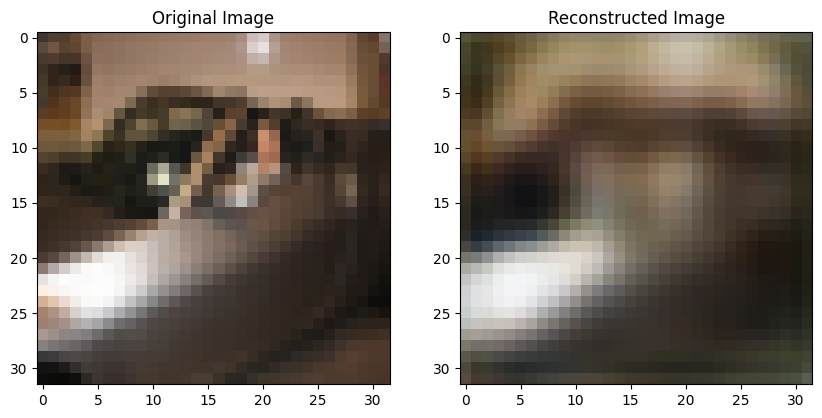

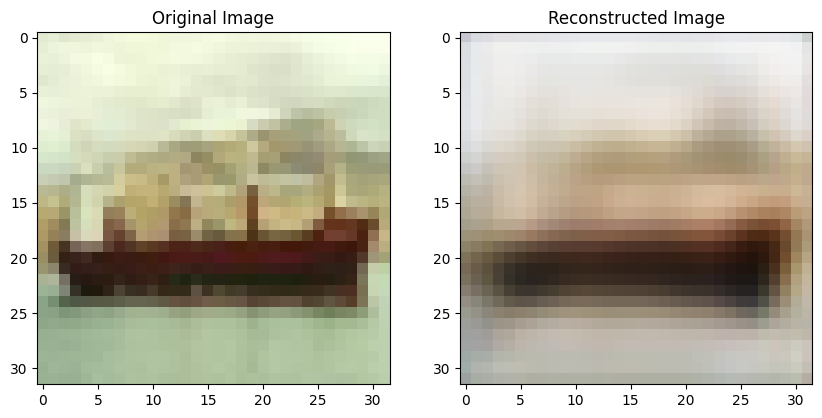

In [ ]:
plot_examples(autoencoder, num_examples=5)

## Exercise 2

1. What is the size of the latent space representation of the above network?


To compute the size of the latent space representation we need to apply the following formula:
$$\left(\frac{W-K+2P}{S}+1\right)^2 \cdot C$$
in which:
- $W$ is the input volume
- $K$ is the kernel size
- $P$ is the padding
- $S$ is the stride
- $C$ is the number of channels

Applying that for each layer we get that:
Econder part:
- first convolutional layer: $32\cdot32\cdot8$
- first max pooling: $16\cdot 16 \cdot 8$
- second convolutional layer: $16\cdot16\cdot12$
- second max pooling: $8\cdot8\cdot12$
- third convolutional layer: $8\cdot8\cdot16$

Decoder part:
- first upsample layer: $3\cdot3\cdot16$
- first convolutional layer: $3\cdot3\cdot12$
- second upsample layer: $(\frac{3}{2})^2 \cdot 12$
- second convolutional layer: $3$


2. Try other architectures (e.g. fewer intermediate layers, different number of channels, filter sizes or stride and
padding configurations) to answer questions such as: What is the impact of those in the reconstruction error
after training? Is there an obvious correlation between the size of the latent space representation and the error?

i risultati andrebbero magari rappresentati in some way per rispondere bene alle domande. capiamo se ha senso sto metodo.

## Exercise 3


1. Adapt your network from the previous part such that it learns to reconstruct colors by feeding in grayscale
images but predicting all RGB channels. As a starting point, use the hyperparameters (including the network
architecture) that you identified to yield the best performance in Exercise 2.

In [ ]:
autoencoder_gray = Autoencoder()
autoencoder_gray.train(
    train_loader, test_loader, epochs=EPOCHS, lr=0.001, grayscale_input=True
)
autoencoder_gray.plot_loss()

In [ ]:
plot_examples(autoencoder_gray, num_examples=5, grayscale=True)

2. Report on your results and reason about potential shortcomings of your network. What aspects of the architecture/hyperparameters/optimization could be improved upon to fit the model more adequately to this application? Try out some ideas.

Per quello che è riuscito a fare:

The loss around 0.0069 is relatively low, suggesting good reconstruction performance.  <br>
The model using 2 convolutional layers in the encoder and decoder with 8 and 12 channels respectively seems to work well. This suggests a relatively simpler architecture can be effective for this task.<br>

Learning rate (0.001) seems appropriate for this task and 10 epochs appear sufficient for convergence, at least for this specific architecture and hyperparameter combination.